# Explore data

In [1]:
# importing the package
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
data = pd.read_csv("dataset.csv")

In [3]:
data.head()

,SKU,YEAR,WEEK,YEARWEEK,WORKING DAYS,DISCOUNT (%),GIFT,COVID LOCKDOWN,PRICE INCREASE (%),HOLIDAY WEEK,ACTUAL SALES (CS)
0,A,2021,1,202101,6,7,Plastic gift,NO,0,YES,422
1,A,2021,2,202102,6,7,Plastic gift,NO,0,NO,409
2,A,2021,3,202103,6,7,U-gift,NO,0,NO,435
3,A,2021,4,202104,6,7,U-gift,NO,0,NO,446
4,A,2021,5,202105,6,0,NaN,NO,0,NO,370


Aw.. This dataset appears to contain some nan value and even categorical data. I should transform them into numerical types before using them to generate forecasts :)

In [4]:
data.isna().sum()

SKU                     0
YEAR                    0
WEEK                    0
YEARWEEK                0
WORKING DAYS            0
DISCOUNT (%)            0
GIFT                  127
COVID LOCKDOWN          0
PRICE INCREASE (%)      0
HOLIDAY WEEK            0
ACTUAL SALES (CS)       0
dtype: int64

So there are some nan values in column GIFT. However, I assume that it's because gift wasn't included in promotion mechanics at those weeks.

Next step would be transforming categorical data.

#### Transform data

In [5]:
data['GIFT'].drop_duplicates()

0      Plastic gift
2            U-gift
4               NaN
11    Ceramics gift
Name: GIFT, dtype: object

In [6]:
data['COVID LOCKDOWN'].drop_duplicates()

0      NO
26    YES
Name: COVID LOCKDOWN, dtype: object

In [7]:
data['HOLIDAY WEEK'].drop_duplicates()

0    YES
1     NO
Name: HOLIDAY WEEK, dtype: object

In [8]:
data['COVID LOCKDOWN'].replace({'YES': 1, 'NO': 0}, inplace=True)
data['HOLIDAY WEEK'].replace({'YES': 1, 'NO': 0}, inplace=True)

In [9]:
data = pd.get_dummies(data, columns = ['GIFT'])

In [10]:
data

,SKU,YEAR,WEEK,YEARWEEK,WORKING DAYS,DISCOUNT (%),COVID LOCKDOWN,PRICE INCREASE (%),HOLIDAY WEEK,ACTUAL SALES (CS),GIFT_Ceramics gift,GIFT_Plastic gift,GIFT_U-gift
0,A,2021,1,202101,6,7,0,0,1,422,0,1,0
1,A,2021,2,202102,6,7,0,0,0,409,0,1,0
2,A,2021,3,202103,6,7,0,0,0,435,0,0,1
3,A,2021,4,202104,6,7,0,0,0,446,0,0,1
4,A,2021,5,202105,6,0,0,0,0,370,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,B,2022,22,202222,6,0,0,0,0,0,0,0,0
152,B,2022,23,202223,6,0,0,0,0,0,0,0,0
153,B,2022,24,202224,6,25,0,0,0,0,0,0,0
154,B,2022,25,202225,6,25,0,0,0,0,0,0,0


#### Done transforming the dataset into numerical ones.

#### Clean abnormal data points (if any)

In [11]:
historical_data = data[data['YEARWEEK'] <= 202214]
data_graph = pd.pivot_table(historical_data, values = 'ACTUAL SALES (CS)', index=['YEARWEEK'], columns = 'SKU').reset_index()
data_graph['YEARWEEK'] = data_graph['YEARWEEK'].astype(str)

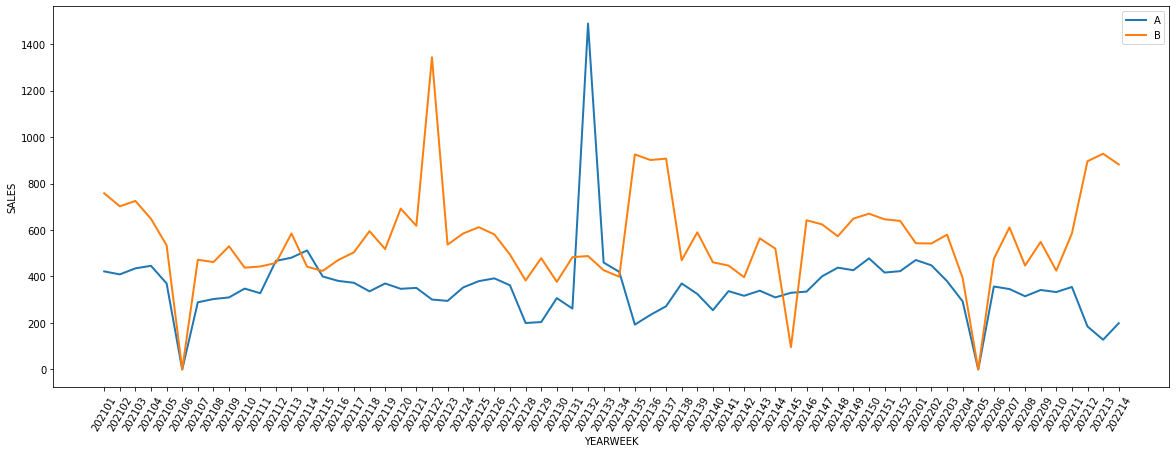

In [12]:
fig, ax = plt.subplots(figsize=[20, 7])

ax.plot(data_graph['YEARWEEK'],
         data_graph['A'], linewidth=2, label='A')
ax.plot(data_graph['YEARWEEK'],
         data_graph['B'], linewidth=2, label='B')
plt.xticks(rotation=60)
ax.set_xlabel('YEARWEEK')
ax.set_ylabel('SALES')
plt.legend()
plt.show()

There are some abnormal points as I can see on the graph. I would like to go into more details.

In [13]:
# remove weeks with working days = 0
historical_data = historical_data[historical_data['WORKING DAYS'] > 0]

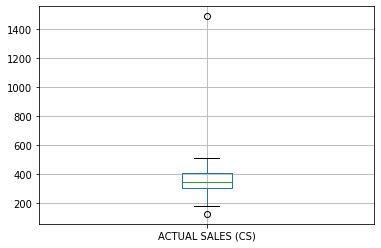

In [14]:
# remove abnormal points
data_a = historical_data[historical_data['SKU'] == 'A']
data_a.boxplot(column=['ACTUAL SALES (CS)'])
plt.show()

In [15]:
data_a = data_a[(data_a['ACTUAL SALES (CS)'] < 1400)]

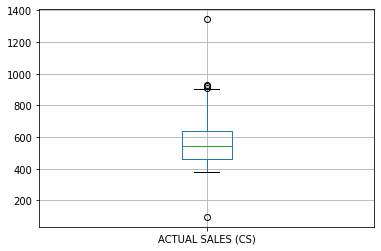

In [16]:
data_b = historical_data[historical_data['SKU'] == 'B']
data_b.boxplot(column=['ACTUAL SALES (CS)'])
plt.show()

In [17]:
data_b = data_b[(data_b['ACTUAL SALES (CS)'] < 1200)&(data_b['ACTUAL SALES (CS)'] > 200)]

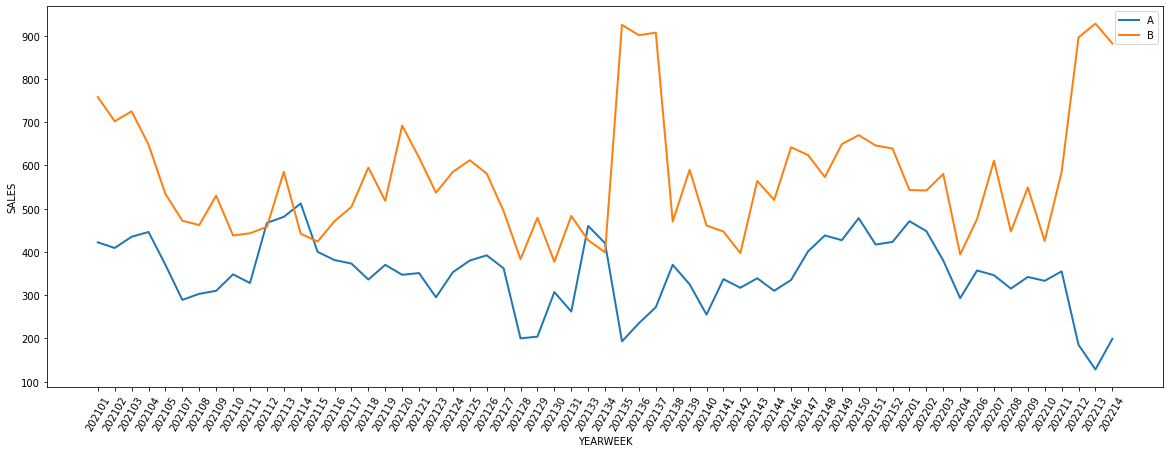

In [18]:
data_graph = data_graph[(data_graph['A'] < 1400)&((data_graph['B'] < 1200) & (data_graph['B'] > 200))]
fig, ax = plt.subplots(figsize=[20, 7])

ax.plot(data_graph['YEARWEEK'],
         data_graph['A'], linewidth=2, label='A')
ax.plot(data_graph['YEARWEEK'],
         data_graph['B'], linewidth=2, label='B')
plt.xticks(rotation=60)
ax.set_xlabel('YEARWEEK')
ax.set_ylabel('SALES')
plt.legend()
plt.show()

# Define features

There is also abnormal sale behaviors in 202135, 202136, 202137 and 202212, 202213, 202214 where sales of SKU B are peaked up dramatically while sales of SKU A dropped significantly. I would like to verify if there is a sign of cannibalization or not.

In [19]:
historical_data[((historical_data['YEARWEEK'] >= 202135)&(historical_data['YEARWEEK'] <= 202137))|((historical_data['YEARWEEK'] >= 202212)&(historical_data['YEARWEEK'] <= 202214))]

,SKU,YEAR,WEEK,YEARWEEK,WORKING DAYS,DISCOUNT (%),COVID LOCKDOWN,PRICE INCREASE (%),HOLIDAY WEEK,ACTUAL SALES (CS),GIFT_Ceramics gift,GIFT_Plastic gift,GIFT_U-gift
34,A,2021,35,202135,5,0,1,0,1,193,1,0,0
35,A,2021,36,202136,6,0,1,0,0,235,1,0,0
36,A,2021,37,202137,6,0,0,0,0,272,1,0,0
63,A,2022,12,202212,6,0,0,0,0,185,0,0,0
64,A,2022,13,202213,6,0,0,5,0,128,0,0,0
65,A,2022,14,202214,6,0,0,0,0,199,0,0,0
112,B,2021,35,202135,5,25,1,0,1,925,0,0,0
113,B,2021,36,202136,6,25,1,0,0,901,0,0,0
114,B,2021,37,202137,6,25,0,0,0,907,0,0,0
141,B,2022,12,202212,6,25,0,0,0,896,0,0,0


In [20]:
data['DISCOUNT (%)'].describe()

count    156.000000
mean       4.820513
std        7.124231
min        0.000000
25%        0.000000
50%        0.000000
75%        7.250000
max       25.000000
Name: DISCOUNT (%), dtype: float64

In these abrnomal weeks, I can see that SKU B is discounted at the highest rate while SKU A is plainly run without promotion. So my assumption here is that there was a cannibalization behaviour between two SKUs.

In [21]:
data[data['DISCOUNT (%)'] == 25]

,SKU,YEAR,WEEK,YEARWEEK,WORKING DAYS,DISCOUNT (%),COVID LOCKDOWN,PRICE INCREASE (%),HOLIDAY WEEK,ACTUAL SALES (CS),GIFT_Ceramics gift,GIFT_Plastic gift,GIFT_U-gift
112,B,2021,35,202135,5,25,1,0,1,925,0,0,0
113,B,2021,36,202136,6,25,1,0,0,901,0,0,0
114,B,2021,37,202137,6,25,0,0,0,907,0,0,0
141,B,2022,12,202212,6,25,0,0,0,896,0,0,0
142,B,2022,13,202213,6,25,0,0,0,928,1,0,0
143,B,2022,14,202214,6,25,0,0,0,882,1,0,0
153,B,2022,24,202224,6,25,0,0,0,0,0,0,0
154,B,2022,25,202225,6,25,0,0,0,0,0,0,0
155,B,2022,26,202226,6,25,0,0,0,0,0,0,0


In [22]:
data[(data['YEARWEEK'] >= 202224)&(data['YEARWEEK'] <= 202226)]

,SKU,YEAR,WEEK,YEARWEEK,WORKING DAYS,DISCOUNT (%),COVID LOCKDOWN,PRICE INCREASE (%),HOLIDAY WEEK,ACTUAL SALES (CS),GIFT_Ceramics gift,GIFT_Plastic gift,GIFT_U-gift
75,A,2022,24,202224,6,0,0,0,0,0,0,0,0
76,A,2022,25,202225,6,0,0,0,0,0,0,0,0
77,A,2022,26,202226,6,0,0,0,0,0,0,0,0
153,B,2022,24,202224,6,25,0,0,0,0,0,0,0
154,B,2022,25,202225,6,25,0,0,0,0,0,0,0
155,B,2022,26,202226,6,25,0,0,0,0,0,0,0


In [23]:
def map_cannibalize(yearweek, sku):
    if yearweek in [202212, 202213, 202214, 202135, 202136, 202137, 202224, 202225, 202226] and sku == 'A':
        return -1
    elif yearweek in [202212, 202213, 202214, 202135, 202136, 202137, 202224, 202225, 202226] and sku == 'B':
        return 1
    else:
        return 0
data['CANNIBALIZATION'] = data.apply(lambda x: map_cannibalize(x['YEARWEEK'], x['SKU']), axis=1)
data_a['CANNIBALIZATION'] = data_a.apply(lambda x: map_cannibalize(x['YEARWEEK'], x['SKU']), axis=1)
data_b['CANNIBALIZATION'] = data_b.apply(lambda x: map_cannibalize(x['YEARWEEK'], x['SKU']), axis=1)

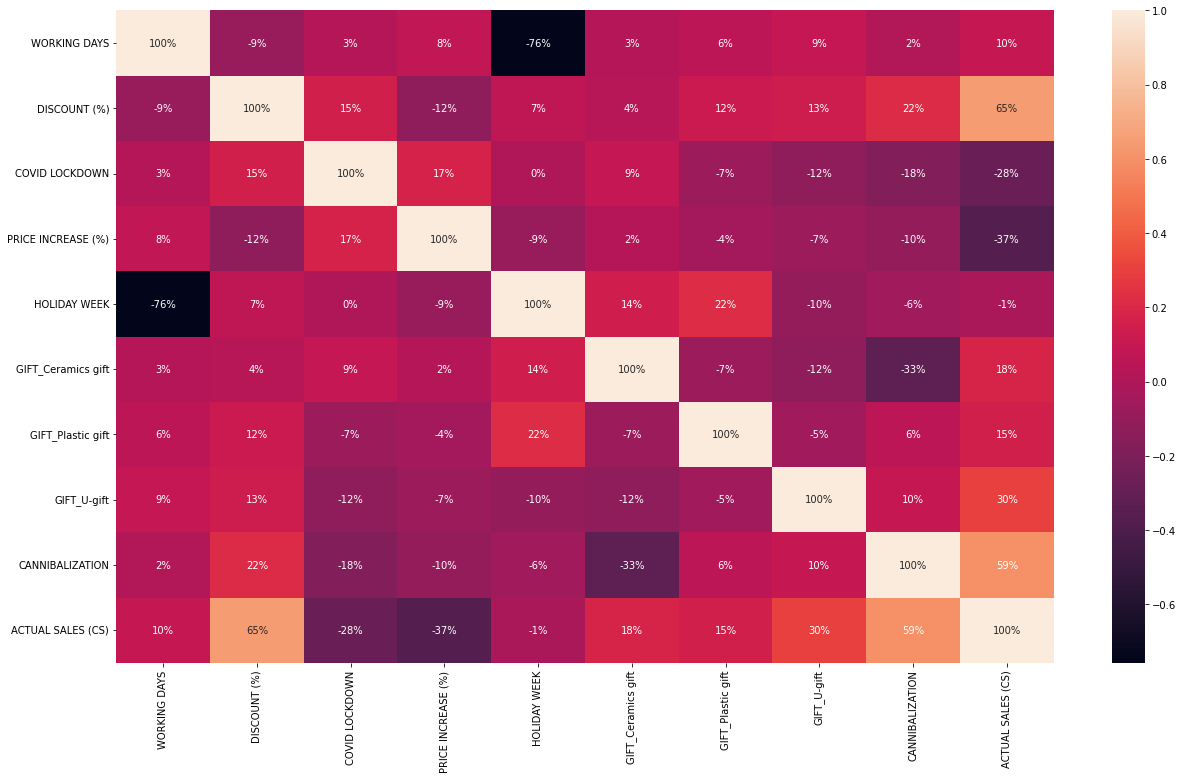

In [24]:
# Define features for SKU A:
data_a = data_a[['WORKING DAYS', 'DISCOUNT (%)', 'COVID LOCKDOWN', 'PRICE INCREASE (%)', 'HOLIDAY WEEK', 'GIFT_Ceramics gift', 'GIFT_Plastic gift', 'GIFT_U-gift', 'CANNIBALIZATION', 'ACTUAL SALES (CS)']]
plt.figure(figsize=(21,12))
sns.heatmap(data_a.corr(), annot=True, fmt ='.0%')
plt.show()

Features most impacting: Discount (%), Covid lockdown, Price increase, U-gift, Cannibalization

In [25]:
data_a = data_a[['DISCOUNT (%)', 'COVID LOCKDOWN', 'PRICE INCREASE (%)', 'GIFT_U-gift', 'CANNIBALIZATION', 'ACTUAL SALES (CS)']]

In [26]:
x_a = data_a.iloc[:,:5]
y_a = data_a.iloc[:,5]
x_a = sm.add_constant(x_a)

In [27]:
model_a = sm.OLS(y_a, x_a).fit()
model_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ACTUAL SALES (CS)   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     40.17
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           1.77e-17
Time:                        23:37:29   Log-Likelihood:                -317.92
No. Observations:                  63   AIC:                             647.8
Df Residuals:                      57   BIC:                             660.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                338.0694      6.812     49.631      0.000     324.429     351.709
DISCOUNT (%)           8.4078      1.010      8.324      0.000       6.385      10.430
COVID LOCKDOWN       -54.9435     15.127     -3.632      0.001     -85.234     -24.653
PRICE INCREASE (%)   -11.1283      3.456     -3.220      0.002     -18.049      -4.207
GIFT_U-gift           42.5652     18.797      2.264      0.027       4.925      80.206
CANNIBALIZATION      108.4814     17.835      6.083      0.000      72.768     144.195
==============================================================================
Omnibus:                        7.077   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.233
Skew:                           0.699   Prob(JB):                       0.0443
Kurtosis:                       3.646   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

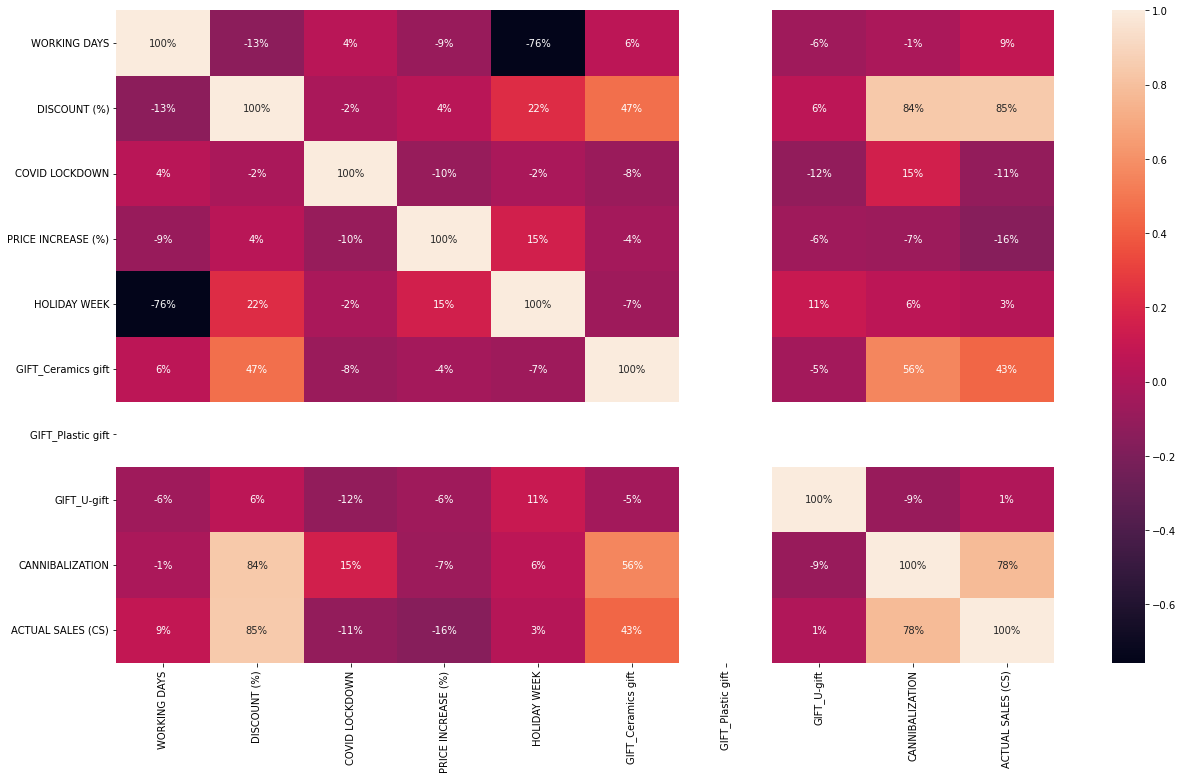

In [28]:
# Define features for SKU B
data_b = data_b[['WORKING DAYS', 'DISCOUNT (%)', 'COVID LOCKDOWN', 'PRICE INCREASE (%)', 'HOLIDAY WEEK', 'GIFT_Ceramics gift', 'GIFT_Plastic gift', 'GIFT_U-gift', 'CANNIBALIZATION', 'ACTUAL SALES (CS)']]
plt.figure(figsize=(21,12))
sns.heatmap(data_b.corr(), annot=True, fmt ='.0%')
plt.show()

Features most impacting: Discount (%), Price increase, Ceramics gift, Cannibalization. However, there is a multicollinearity between cannibalization and ceramics gift. Thus I will choose one feature among these two to input to model.

In [29]:
data_b = data_b[['DISCOUNT (%)', 'PRICE INCREASE (%)', 'CANNIBALIZATION', 'ACTUAL SALES (CS)']]

In [30]:
x_b = data_b.iloc[:,:3]
y_b = data_b.iloc[:,3]
x_b = sm.add_constant(x_b)

In [31]:
model_b = sm.OLS(y_b, x_b).fit()
model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ACTUAL SALES (CS)   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     62.10
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           4.19e-18
Time:                        23:37:31   Log-Likelihood:                -350.52
No. Observations:                  62   AIC:                             709.0
Df Residuals:                      58   BIC:                             717.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                496.9529     11.893     41.787      0.000     473.147     520.759
DISCOUNT (%)          13.3595      2.220      6.018      0.000       8.916      17.803
PRICE INCREASE (%)   -11.3142      4.183     -2.705      0.009     -19.687      -2.942
CANNIBALIZATION       75.5607     57.626      1.311      0.195     -39.791     190.913
==============================================================================
Omnibus:                        5.791   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                2.344
Skew:                           0.060   Prob(JB):                        0.310
Kurtosis:                       2.055   Cond. No.                         59.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Forecast

In [32]:
# Predict SKU A
future_data = data[data['YEARWEEK'] >= 202215]
future_data_a = future_data[future_data['SKU'] == 'A']

In [33]:
predict_data_a = future_data_a[['DISCOUNT (%)', 'COVID LOCKDOWN', 'PRICE INCREASE (%)', 'GIFT_U-gift', 'CANNIBALIZATION', 'ACTUAL SALES (CS)']]
x_a = predict_data_a.iloc[:,:5]
y_a = predict_data_a.iloc[:,5]
x_a = sm.add_constant(x_a)
future_data_a['Predictions'] = model_a.predict(x_a)
future_data_a

C:\Users\Truong-Ngoc.Linh\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,SKU,YEAR,WEEK,YEARWEEK,WORKING DAYS,DISCOUNT (%),COVID LOCKDOWN,PRICE INCREASE (%),HOLIDAY WEEK,ACTUAL SALES (CS),GIFT_Ceramics gift,GIFT_Plastic gift,GIFT_U-gift,CANNIBALIZATION,Predictions
66,A,2022,15,202215,6,0,0,0,0,0,0,0,0,0,338.069412
67,A,2022,16,202216,6,0,0,0,0,0,0,0,0,0,338.069412
68,A,2022,17,202217,5,0,0,0,0,0,0,0,0,0,338.069412
69,A,2022,18,202218,5,8,0,0,0,0,0,0,0,0,405.332068
70,A,2022,19,202219,6,8,0,0,0,0,0,0,0,0,405.332068
71,A,2022,20,202220,6,8,0,0,0,0,0,0,0,0,405.332068
72,A,2022,21,202221,6,15,0,0,0,0,0,1,0,0,464.186893
73,A,2022,22,202222,6,15,0,0,0,0,0,1,0,0,464.186893
74,A,2022,23,202223,6,15,0,5,0,0,0,1,0,0,408.545569
75,A,2022,24,202224,6,0,0,0,0,0,0,0,0,-1,229.588049


In [34]:
# Predict SKU B
future_data = data[data['YEARWEEK'] >= 202215]
future_data_b = future_data[future_data['SKU'] == 'B']

In [35]:
predict_data_b = future_data_b[['DISCOUNT (%)', 'PRICE INCREASE (%)', 'CANNIBALIZATION', 'ACTUAL SALES (CS)']]
x_b = predict_data_b.iloc[:,:3]
y_b = predict_data_b.iloc[:,3]
x_b = sm.add_constant(x_b)
future_data_b['Predictions'] = model_b.predict(x_b)
future_data_b

C:\Users\Truong-Ngoc.Linh\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,SKU,YEAR,WEEK,YEARWEEK,WORKING DAYS,DISCOUNT (%),COVID LOCKDOWN,PRICE INCREASE (%),HOLIDAY WEEK,ACTUAL SALES (CS),GIFT_Ceramics gift,GIFT_Plastic gift,GIFT_U-gift,CANNIBALIZATION,Predictions
144,B,2022,15,202215,6,0,0,0,0,0,1,0,0,0,496.952948
145,B,2022,16,202216,6,0,0,7,0,0,0,0,0,0,417.753519
146,B,2022,17,202217,5,0,0,0,0,0,0,0,0,0,496.952948
147,B,2022,18,202218,5,12,0,0,0,0,0,0,1,0,657.266387
148,B,2022,19,202219,6,12,0,0,0,0,0,0,1,0,657.266387
149,B,2022,20,202220,6,12,0,0,0,0,0,0,1,0,657.266387
150,B,2022,21,202221,6,0,0,0,0,0,0,0,0,0,496.952948
151,B,2022,22,202222,6,0,0,0,0,0,0,0,0,0,496.952948
152,B,2022,23,202223,6,0,0,0,0,0,0,0,0,0,496.952948
153,B,2022,24,202224,6,25,0,0,0,0,0,0,0,1,906.500000


In [36]:
future_data_a.to_csv("sku_a.csv")
future_data_b.to_csv("sku_b.csv")

# Done!